In [ ]:

from google.colab import drive
drive.mount('/content/drive')

!pip install -q hampel seaborn

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

import os, re, pickle
import numpy as np
import pandas as pd
from math import sqrt
from hampel import hampel
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:

main_folder_path = '/content/drive/MyDrive/activity----raw'
filtered_base_dir = '/content/drive/MyDrive/filtered'
scaler_save_dir  = '/content/drive/MyDrive/csi_scalers/'
model_save_path  = '/content/drive/MyDrive/csi_activity_model_final.h5'
encoder_save_path = '/content/drive/MyDrive/label_encoder.pkl'

WINDOW_LEN = 200
OVERLAP = 0
PAD_SHORT = False
random_state = 42

os.makedirs(filtered_base_dir, exist_ok=True)
os.makedirs(scaler_save_dir, exist_ok=True)


In [ ]:
=

def parse_csi_row(csi_string):
    if not isinstance(csi_string, str):
        return None
    inner = re.findall(r'\[(.*)\]', csi_string)
    if not inner:
        return None
    parts = [p for p in inner[0].split() if p != '']
    try:
        nums = [int(x) for x in parts]
    except:
        try:
            nums = [float(x) for x in parts]
        except:
            return None
    if len(nums) % 2 != 0:
        nums = nums[:-1]
    imag = nums[0::2]
    real = nums[1::2]
    return [sqrt(i*i + r*r) for i,r in zip(imag, real)]

activity_dataframes, label_list = [], []

for folder in sorted(os.listdir(main_folder_path)):
    folder_path = os.path.join(main_folder_path, folder)
    if not os.path.isdir(folder_path): continue
    for fname in sorted(os.listdir(folder_path)):
        if not fname.lower().endswith('.csv'): continue

        fpath = os.path.join(folder_path, fname)
        try:
            df = pd.read_csv(fpath)
        except:
            print("Error reading:", fpath)
            continue

        rows = []
        for _, row in df.iterrows():
            amps = parse_csi_row(row.get('CSI_DATA'))
            if amps is not None: rows.append(amps)

        if len(rows) == 0:
            print("No CSI in:", fpath)
            continue

        mat = pd.DataFrame(rows)
        activity_dataframes.append(mat)
        label_list.append(folder)

print("✅ Loaded", len(activity_dataframes), "files")

✅ Loaded 30 files


In [ ]:


denoised = []
for i, (df, lab) in enumerate(zip(activity_dataframes, label_list)):
    filt = pd.DataFrame()
    for col in df.columns:
        series = df[col].values
        try:
            h = hampel(series, window_size=10)
            sg = savgol_filter(h.filtered_data, 5, 3)
        except:
            sg = series
        filt[col] = sg

    denoised.append(filt)

    out_dir = os.path.join(filtered_base_dir, lab)
    os.makedirs(out_dir, exist_ok=True)
    filt.to_csv(os.path.join(out_dir, f"{lab}_{i+1}.csv"), index=False)

In [ ]:

col_counts = [df.shape[1] for df in denoised]
target_cols = min(col_counts)

for i, df in enumerate(denoised):
    if df.shape[1] > target_cols:
        denoised[i] = df.iloc[:, :target_cols]
    elif df.shape[1] < target_cols:
        pad = pd.DataFrame(np.zeros((df.shape[0], target_cols - df.shape[1])))
        denoised[i] = pd.concat([df, pad], axis=1)

In [ ]:


def segment(matrices, labels, win=200, overlap=0):
    segs, labs = [], []
    step = win - overlap
    for df, lab in zip(matrices, labels):
        arr = df.values
        T, C = arr.shape
        if T < win:
            continue
        for s in range(0, T - win + 1, step):
            segs.append(arr[s:s+win])
            labs.append(lab)
    return np.array(segs), np.array(labs)

segments, seg_labels = segment(denoised, label_list, WINDOW_LEN, OVERLAP)
print("✅ Segments:", segments.shape)

✅ Segments: (956, 200, 64)


In [ ]:


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(seg_labels)
num_classes = len(label_encoder.classes_)


In [ ]:


window_len, subcarriers = X_train_input.shape[1:3]

model = keras.Sequential([
    layers.Conv2D(32, (7,3), padding='same', activation='relu', input_shape=(window_len, subcarriers,1)),
    layers.MaxPooling2D((2,1)),
    layers.Conv2D(64, (5,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:


weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('/content/best_csi_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    X_train_input, y_train,
    validation_data=(X_val_input, y_val),
    epochs=80,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4680 - loss: 1.0546

39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4711 - loss: 1.0499 - val_accuracy: 0.8824 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8034 - loss: 0.5189

39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8031 - loss: 0.5194 - val_accuracy: 0.8889 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8440 - loss: 0.4492

39/39 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8445 - loss: 0.4481 - val_accuracy: 0.9085 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8640 - loss: 0.3136

39/39 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8641 - loss: 0.3136 - val_accuracy: 0.9020 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8874 - loss: 0.2732 - val_accuracy: 0.9085 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9116 - loss: 0.2546 - val_accuracy: 0.8954 - val_loss: 0.2777 - learning_rate: 1.0000e-04
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9062 - loss: 0.2228

39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9067 - loss: 0.2223 - val_accuracy: 0.9150 - val_loss: 0.2613 - learning_rate: 1.0000e-04
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - loss: 0.1510

39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9555 - loss: 0.1515 - val_accuracy: 0.9216 - val_loss: 0.2418 - learning_rate: 1.0000e-04
Epoch 9/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9288 - loss: 0.1896 - val_accuracy: 0.9216 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 10/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9505 - loss: 0.1511 - val_accuracy: 0.9150 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 11/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9645 - loss: 0.0966 - val_accuracy: 0.9216 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 12/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9714 - loss: 0.0743

39/39 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9712 - loss: 0.0749 - val_accuracy: 0.9216 - val_loss: 0.2064 - learning_rate: 1.0000e-04
Epoch 13/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9706 - loss: 0.0985 - val_accuracy: 0.9150 - val_loss: 0.2555 - learning_rate: 1.0000e-04
Epoch 14/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9763 - loss: 0.0796 - val_accuracy: 0.9150 - val_loss: 0.2892 - learning_rate: 1.0000e-04
Epoch 15/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9902 - loss: 0.0590 - val_accuracy: 0.9085 - val_loss: 0.2500 - learning_rate: 1.0000e-04
Epoch 16/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9751 - loss: 0.0594 - val_accuracy: 0.9216 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 17/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9687 - loss: 0.0765
Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
39/39 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9685 - loss: 0.0768 - v

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9092 - loss: 0.2514
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 975ms/step
✅ Accuracy: 0.890625
              precision    recall  f1-score   support

     sitting       0.86      0.84      0.85        44
    sleeping       0.89      0.97      0.93        69
     walking       0.91      0.85      0.88        79

    accuracy                           0.89       192
   macro avg       0.89      0.89      0.89       192
weighted avg       0.89      0.89      0.89       192



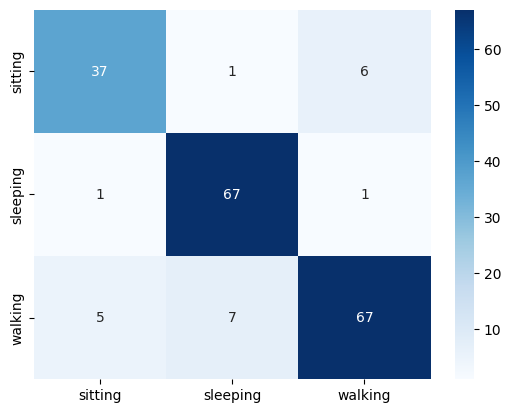

In [ ]:


test_loss, test_acc = model.evaluate(X_test_input, y_test)
y_pred = np.argmax(model.predict(X_test_input), axis=1)

print("✅ Accuracy:", test_acc)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.show()

In [ ]:


model.save(model_save_path)

with open(encoder_save_path, "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ MODEL TRAINED & SAVED SUCCESSFULLY!")

✅ MODEL TRAINED & SAVED SUCCESSFULLY!
